# Nuclei segmentation using StarDist

In this tutorial, we show how we can use the `StarDist` segmentation method in `squidpy.im.segment` for nuclei segmentation. 

**StarDist** <cite data-cite="stardist_schmidt2018">Schmidt et al. (2018)</cite> and <cite data-cite="stardist_weigert2020">Weigert et al. (2020)</cite> , ([code](https://github.com/stardist/stardist))  uses star-convex polygons to localize cell for which a convolutional neural network was trained to predict pixel-wise polygons for each cell position. 

To run the notebook locally, create a conda environment as *conda env create -f stardist_environment.yml* using this [stardist_environment.yml](https://github.com/scverse/squidpy_notebooks/blob/main/envs/stardist_environment.yml), which installs Squidpy, TensorFlow, and StarDist.

**Note:** We frequently recognized a dying notebook kernel when importing other packages before StarDist with the following message "The kernel appears to have died. It will restart automatically." We therefore recommend to import StarDist first.

In [1]:
# Import the StarDist 2D segmentation models.
# Import the recommended normalization technique for stardist.
from csbdeep.utils import normalize
from stardist.models import StarDist2D

import numpy as np

import matplotlib.pyplot as plt

# Import squidpy and additional packages needed for this tutorial.
import squidpy as sq

StarDist has four pre-trained models for 2D images. We will show an example for the Versatile (fluorescent nuclei) model and the Versatile (H&E nuclei). To use the StarDist model, we define a wrapper that normalizes the image with the recommended method, initializes the model and returns the segmentation mask. 

In [2]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


The method parameter of the `sq.im.segment` method accepts any callable with the signature:
`numpy.ndarray` ``(height, width, channels)`` **->** `numpy.ndarray` ``(height, width[, channels])``. Additional model specific arguments will also be passed on. 

## Cell segmentation on Visium fluorescence data


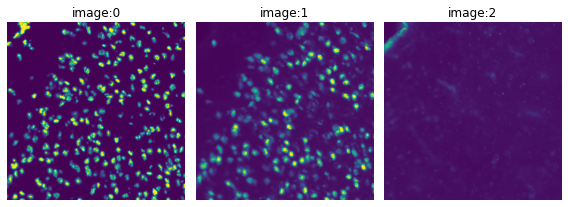

In [3]:
# Load the image and visualize its channels.
img = sq.datasets.visium_fluo_image_crop()
crop = img.crop_corner(1000, 1000, size=1000)
crop.show(channelwise=True)

Additionally, we will have a look at the pre-trained StarDist model. The `2D_versatile_fluo model` works on one channel, as `n_channel_in = 1`. We will run the segmentation on the first channel of the image in this example. 

In [4]:
StarDist2D.from_pretrained("2D_versatile_fluo")

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


StarDist2D(2D_versatile_fluo): YXC → YXC
├─ Directory: None
└─ Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=800, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.2], train_n_val_patches=None, train_patch_size=[256, 256], train_reduce_lr={'factor': 0.5, 'patience': 80, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=400, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=[3, 3], unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=[2, 2], unet_prefix='', use_gp

The input image is normalized beforehand by supplying a `normalizer` to the prediction function. We pass the recommended StarDist normalization method from `csbdeep.utils` into our callable.

Calling `model.predict_instances` will:

- predict object probabilities and star-convex polygon distances.
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image.
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons.

For our purpose, we will only return the respective labels. Check the detailed example StarDist [notebook](https://github.com/stardist/stardist/blob/main/examples/2D/3_prediction.ipynb) for more information.

In [5]:
def stardist_2D_versatile_fluo(img, nms_thresh=None, prob_thresh=None):
    # Make sure to normalize the input image beforehand or supply a normalizer to the prediction function.
    # this is the default normalizer noted in StarDist examples.
    img = normalize(img, 1, 99.8, axis=(0, 1))
    model = StarDist2D.from_pretrained("2D_versatile_fluo")
    labels, _ = model.predict_instances(
        img, nms_thresh=nms_thresh, prob_thresh=prob_thresh
    )
    return labels

In [6]:
sq.im.segment(
    img=crop,
    layer="image",
    channel=0,
    method=stardist_2D_versatile_fluo,
    layer_added="segmented_stardist",
    nms_thresh=None,
    prob_thresh=None,
)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_stardist']]
Number of segments in crop: 412


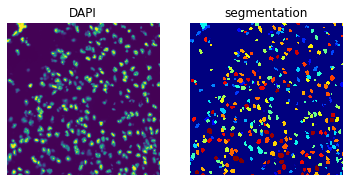

In [7]:
# Plot the DAPI channel of the image crop and the segmentation result.
print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_stardist']))}")

fig, axes = plt.subplots(1, 2)
crop.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("DAPI")
crop.show("segmented_stardist", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")

## Cell segmentation on H&E stained tissue data

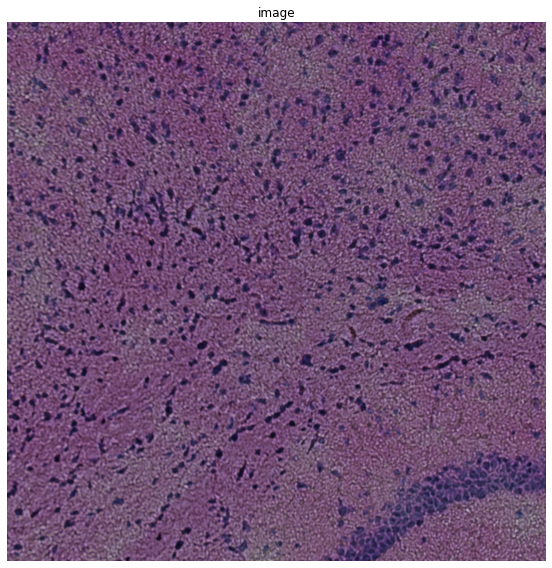

In [8]:
# load H&E stained tissue image and crop to a smaller segment
img = sq.datasets.visium_hne_image_crop()
crop = img.crop_corner(0, 0, size=1000)
crop.show("image")

In [9]:
def stardist_2D_versatile_he(img, nms_thresh=None, prob_thresh=None):
    # axis_norm = (0,1)   # normalize channels independently
    axis_norm = (0, 1, 2)  # normalize channels jointly
    # Make sure to normalize the input image beforehand or supply a normalizer to the prediction function.
    # this is the default normalizer noted in StarDist examples.
    img = normalize(img, 1, 99.8, axis=axis_norm)
    model = StarDist2D.from_pretrained("2D_versatile_he")
    labels, _ = model.predict_instances(
        img, nms_thresh=nms_thresh, prob_thresh=prob_thresh
    )
    return labels

StarDist H&E segmentation method works on three input channels as `n_channel_in = 3`. We therefore pass `channel = None` 
 to the `sq.img.segment` method which will then run the given segmentation method on all given channels.

In [10]:
StarDist2D.from_pretrained("2D_versatile_he")

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


StarDist2D(2D_versatile_he): YXC → YXC
├─ Directory: None
└─ Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=3, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 3], net_mask_shape=[None, None, 1], train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=200, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.1], train_n_val_patches=3, train_patch_size=[512, 512], train_reduce_lr={'factor': 0.5, 'patience': 50, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=200, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=[3, 3], unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=[2, 2], unet_prefix='', use_gpu=Fal

In [11]:
sq.im.segment(
    img=crop,
    layer="image",
    channel=None,
    method=stardist_2D_versatile_he,
    layer_added="segmented_stardist_default",
    prob_thresh=None,
    nms_thresh=None,
)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_stardist_default']]
Number of segments in crop: 193


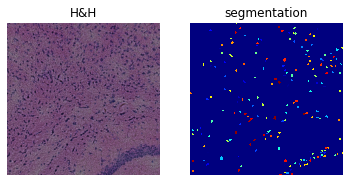

In [12]:
print(crop)
print(
    f"Number of segments in crop: {len(np.unique(crop['segmented_stardist_default']))}"
)

fig, axes = plt.subplots(1, 2)
crop.show("image", ax=axes[0])
_ = axes[0].set_title("H&H")
crop.show("segmented_stardist_default", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")

Adjusting the `prob_thresh` parameter will enhance the segmentation. We show this additionally for `prob_thresh = 0.3`. Please be aware that the print statement of the default values will remain unchanged, even if you adjusted the parameters.

In [13]:
sq.im.segment(
    img=crop,
    layer="image",
    channel=None,
    method=stardist_2D_versatile_he,
    layer_added="segmented_stardist",
    prob_thresh=0.3,
    nms_thresh=None,
)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


ImageContainer[shape=(1000, 1000), layers=['image', 'segmented_stardist', 'segmented_stardist_default']]
Number of segments in crop: 632


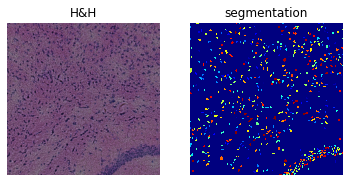

In [14]:
print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_stardist']))}")

fig, axes = plt.subplots(1, 2)
crop.show("image", ax=axes[0])
_ = axes[0].set_title("H&H")
crop.show("segmented_stardist", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")